In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, skewnorm, cauchy, lognorm
import logging
import json
import sys
import os

In [2]:
#get dataframe format to support plotting of results
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
    "Latin America","OHI","Other non-OECD Asia"]

"""
####################### Population PARAMETERS and set up dataframe format #######################
"""
#get population growth rates for each region
a=[]
for i in range(31):  
    if i == 0:
        a.append("region")
    k = 2005 + 10 * i
    k = str(k)
    a.append(k)    

region_pop_gr = RICE_POP_gr.iloc[10:22,3:35]
region_pop_gr.columns =  a
region_pop_gr = region_pop_gr.set_index('region') 

In [33]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, skewnorm, cauchy, lognorm
import logging
import json
import sys
import os

pydice_folder = os.path.dirname(os.getcwd())

print('local path in PyRICE = ')
print(pydice_folder)

sys.path.append(pydice_folder)


class PyRICE(object):
    """ RICE simulation model:
        tstep: time step/interval
        steps: amount of years looking into the future
        model_specification: model specification for 'EMA_det', 'EMA_dist' or 'Validation'  
    """
    def __init__(self, tstep=10, steps=31, model_specification="Validation_2",fdamage = 1):


        self.tstep = tstep # (in years)
        self.steps = steps
        self.tperiod = []
        self.startYear = 2005
        self.model_specification = model_specification
        self.fdamage = fdamage
        
        
        ########################## SAMPLING OF DAMAGE FUNCTIONS ##########################
        

        #arrange simulation timeline
        for i in range(0, self.steps):
            self.tperiod.append((i*self.tstep)+self.startYear)

        #setup of json file to store model results
        with open(pydice_folder + '\\ecs_dist_v5.json') as f:
            d=json.load(f)

        #setting up three distributions for the climate sensitivity; normal lognormal and gauchy

        #creating a list from the dist of t2xC02
        np.random.seed(10)

        minb = 0
        maxb = 20
        nsamples = 1000

        samples_norm = np.zeros((0,))
        while samples_norm.shape[0] < nsamples:
            samples = (norm.rvs(d['norm'][0],d['norm'][1],nsamples))
            accepted = samples[(samples >= minb) & (samples <= maxb)]
            samples_norm = np.concatenate((samples_norm, accepted), axis=0)
        samples_norm = samples_norm[:nsamples]

        samples_lognorm = np.zeros((0,))
        while samples_lognorm.shape[0] < nsamples:
            samples = (lognorm.rvs(d['lognorm'][0],d['lognorm'][1],d['lognorm'][2],nsamples))
            accepted = samples[(samples >= minb) & (samples <= maxb)]
            samples_lognorm = np.concatenate((samples_lognorm, accepted), axis=0)
        samples_lognorm = samples_lognorm[:nsamples]

        samples_cauchy = np.zeros((0,))
        while samples_cauchy.shape[0] < nsamples:
            samples = (cauchy.rvs(d['cauchy'][0],d['cauchy'][1],nsamples))
            accepted = samples[(samples >= minb) & (samples <= maxb)]
            samples_cauchy = np.concatenate((samples_cauchy, accepted), axis=0)
        samples_cauchy = samples_cauchy[:nsamples]

        # extend array with the deterministic value of the nordhau
        samples_norm = np.append(samples_norm, 3.2)
        samples_lognorm = np.append(samples_lognorm, 3.2)
        samples_cauchy = np.append(samples_cauchy, 3.2)

        self.samples_t2xco2 = [samples_norm, samples_lognorm, samples_cauchy]


    def __call__(self,
        #uncertainties from Nordhaus(2010) (first draft)
        t2xco2_index = -1,
        t2xco2_dist = 0,
        fosslim =6000,
        sample_factor_pop_gr = 1,
        sample_factor_sigma_gr = 1,
        sample_factor_tfp_gr = 1,
        sample_factor_c_back = 1,
                 
        #decl_back_gr=0.025         
        
        sr = 0.249,           # Savings rate is very different for every region --> how to implement in non optimized RICE?

        periodfullpart=7,      #in OPT RICE period full part is 2075
        miu_period=13,          #2155 in RICE opt scenario when global emissions are near zero
        limmiu=1,    #Upper limit on control rate after 2150, in RICE 1 
        fdamage=1,   #0 is original damage function in RICE 1 is fitted SLR BUILT IN SHAJEE DAMAGE FUNCTIONS
        irstp = 0.015,   # Initial rate of social time preference (per year) (0.015) (RICE2010 OPT))        
        **kwargs):

        """
        ######################## INITIALIZE DATA IMPORTS ########################
        """
        RICE_DATA = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Data")
        RICE_PARAMETER = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Parameters")
        RICE_DAMAGE = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Damage")
        RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")
        RICE_results = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Results")

        regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
            "Latin America","OHI","Other non-OECD Asia"]
            
        """
        ############################# LEVERS ###############################
        """

        #setting up model levers
        #if model is EMA the emission control rate miu is sampled 
        #if specification is DICE optimal, the optimal control rate range for every region is taken from Nordhaus 


        ###################### GET CONTROLS FROM RICE OPTIMAL RUN #########################
        #Savings rate (optlrsav = 0.2582781457) from the control file
        validation_series = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Validation series")
        
        #get lever series for RICE optimal run
        miu_opt_series = validation_series.iloc[6:18,3:34].to_numpy() 
        sr_opt_series = validation_series.iloc[21:33,3:34].to_numpy()
        

        #Controls with random sampling
        if self.model_specification == "EMA":
            
            #create frame for savings rate to be sampled
            self.S = np.zeros((12, self.steps))
            self.miu = np.zeros((12,self.steps))
            
            #set starting MIU for all runs
            self.miu[:,0:2] = miu_opt_series[:,0:2]
            self.S[:,0:2] = sr_opt_series[:,0:2]
            
            self.miu_period = np.full((12, 1), miu_period)
            self.sr = sr
            
                

        #full RICE2010 replicating run
        if self.model_specification == "Validation_1":
 
            #set savings rate and control rate as optimized RICE 2010          
            self.S =  sr_opt_series 
            Print_S = pd.DataFrame(data=self.S)
            
            print('savings is set')
            print(self.S)

            #set emission control rate for the whole run according to RICE2010 opt.
            self.miu = miu_opt_series
            self.irstp = irstp
            

        #EMA Deterministic
        if self.model_specification == "Validation_2":

            #create dataframes for control rate and savings rate
            self.miu = np.zeros((12,self.steps))
            self.S = np.zeros((12, self.steps))
            
            #set savings rate and control rate as optimized RICE 2010 for the first two timesteps
            self.miu[:,0:2] = miu_opt_series[:,0:2]
            self.S[:,0:2] = sr_opt_series[:,0:2]

            #set uncertainties that drive MIU
            self.limmiu= 1
            self.irstp = irstp
            self.miu_period = [12,15,15,10,10,11,13,13,13,14,13,14]
        
        #define other uncertainties same over all instances
        self.irstp = irstp
        self.limmiu = limmiu
        self.fosslim = fosslim
        
        
        #define growth factor uncertainties for sampling
        self.sample_factor_pop_gr =sample_factor_pop_gr,
        self.sample_factor_sigma_gr = sample_factor_sigma_gr,
        self.sample_factor_tfp_gr = sample_factor_tfp_gr,
        self.sample_factor_c_back = sample_factor_c_back,
                 
        """
        ######################## DEEP UNCERTAINTIES ########################
        """

        # Equilibrium temperature impact [dC per doubling CO2]/
        # CLimate sensitivity parameter (3.2 RICE OPT)
        self.t2xco2 = self.samples_t2xco2[t2xco2_dist][t2xco2_index]

        # Choice of the damage function (structural deep uncertainty)
        self.fdamage = fdamage

        print("used damage function is: ")
        print(self.fdamage)


        """
        ####################### Carbon cycle PARAMETERS #######################
        """            

        #RICE2010 INPUTS
        # Initial concentration in atmosphere 2000 [GtC]
        self.mat0 = 787 
        # Initial concentration in atmosphere 2010 [GtC]
        self.mat1 = 829
        # Initial concentration in upper strata [GtC]
        self.mu0 = 1600.0 #1600 in excel
        # Initial concentration in lower strata [GtC]
        self.ml0 = 10010.0
        # Equilibrium concentration in atmosphere [GtC]
        self.mateq = 588.0 
        # Equilibrium concentration in upper strata [GtC]
        self.mueq = 1500.0 
        # Equilibrium concentration in lower strata [GtC]
        self.mleq = 10000.0

        #parameters are scaled with 100, check with cllimate equations
        self.b11 = 0.088                                   #88 in excel
        self.b23 = 0.00500                                 #0.5 in excel
        self.b12 = 1 -  self.b11                           
        self.b21 =  self.b11 *  self.mateq /  self.mueq    
        self.b22 = 1 -  self.b21 -  self.b23               #good in excel       
        self.b32 =  self.b23 *  self.mueq /  self.mleq     #good in excel
        self.b33 = 1 -  self.b32                           #good in excel       

        # 2000 forcings of non-CO2 greenhouse gases (GHG) [Wm-2]
        self.fex0 = -0.06
        # 2100 forcings of non-CO2 GHG [Wm-2]
        self.fex1 = 0.30
        # Forcings of equilibrium CO2 doubling [Wm-2]
        self.fco22x = 3.8


        """
        ###################### CLIMATE INITIAL VALUES ######################
        """
        #RICE2010 INPUTS

        # Equilibrium temperature impact [dC per doubling CO2]
        # self.t2xco2 = t2xco2
        # Initial lower stratum temperature change [dC from 1900]
        self.tocean0 = 0.0068 
        # Initial atmospheric temperature change [dC from 1900]
        self.tatm0 = 0.83 


        # 2013 version and earlier:
        # Initial climate equation coefficient for upper level
        # self.c10 = 0.098
        # Regression slope coefficient (SoA~Equil TSC)
        # self.c1beta = 0.01243
        # Transient TSC Correction ("Speed of Adjustment Parameter")
        # self.c1 = self.c10+self.c1beta*(self.t2xco2-2.9)

        #DICE2013R
        # Climate equation coefficient for upper level
        #self.c1 = 0.098
        # Transfer coefficient upper to lower stratum
        #self.c3 = 0.088
        # Transfer coefficient for lower level
        #self.c4 = 0.025
        # Climate model parameter
        #self.lam =  self.fco22x /  self.t2xco2

        #RICE2010
        # Climate equation coefficient for upper level
        self.c1 = 0.208
        # Transfer coefficient upper to lower stratum
        self.c3 = 0.310
        # Transfer coefficient for lower level
        self.c4 = 0.05
        # Climate model parameter
        self.lam =  self.fco22x /  self.t2xco2

        """
        ######################### CARBON PARAMETERS ########################
        """

        self.mat = np.zeros((self.steps,))
        self.mu = np.zeros((self.steps,))
        self.ml = np.zeros((self.steps,))
        self.forcoth = np.zeros((self.steps,))
        self.forc = np.zeros((self.steps,))

        """
        ######################## CLIMATE PARAMETERS ########################
        """

        # Increase temperature of atmosphere [dC from 1900]
        self.temp_atm = np.zeros((self.steps,))
        # Increase temperature of lower oceans [dC from 1900]
        self.temp_ocean = np.zeros((self.steps,))


        """
        ######################## DAMAGE PARAMETERS ########################
        """

        #damage parameters excluding SLR from base file 
        damage_parameters = RICE_DAMAGE.iloc[20:28,8:20].to_numpy()
        self.damage_parameters = damage_parameters.transpose()


        #damage parameters INCLUDING SLR FIT Dennig et 
        self.damage_parameters_slr_fit = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="SLR fitted parameters")
        self.damage_parameters_slr_fit = self.damage_parameters_slr_fit.iloc[27:39,13:15].to_numpy()

        #include SHAJEE stuff here
        """
        ####################### Capital and Economic PARAMETERS #######################
        """
        #population parameteers
        self.region_pop_gr = RICE_POP_gr.iloc[10:22,4:35].to_numpy()
        
        #get population data for 2005
        population2005 = RICE_DATA.iloc[19:31,0].to_numpy()
        self.region_pop = np.zeros((12,self.steps))

        #get data for factor productivity growth
        self.tfpgr_region =  RICE_DATA.iloc[52:64,1:32].to_numpy()

        #get initial values for various parameters
        self.initails_par = RICE_PARAMETER.iloc[33:40,5:17].to_numpy()
        self.initials_par = self.initails_par.transpose()

        #setting up total factor productivity
        self.tfp_2005 = self.initials_par[:,5]
        self.tfp_region = np.zeros((12, self.steps))
        
        #setting up capital parameters
        self.k_2005 = self.initials_par[:,4]
        self.k_region = np.zeros((12, self.steps))
        self.dk = 0.1
        self.gama = 0.3

        #setting up Y Gross
        self.Y_gross = np.zeros((12, self.steps))
        self.ynet = np.zeros((12, self.steps))
        self.damages = np.zeros((12, self.steps))
        self.dam_frac = np.zeros((12, self.steps))

        #extra dataframe for calculating exponent - waarschijnlijk overbodig
        self.Sigma_gr_tussenstap = pd.DataFrame(data=np.zeros([12, 1]))
        self.Sigma_gr_tussenstap["exp"] = ""

        #Dataframes for emissions, economy and utility
        self.Eind = np.zeros((12, self.steps))
        self.E = np.zeros((12, self.steps))
        self.Etree = np.zeros((12, self.steps))
        self.cumetree = np.zeros((12, self.steps))
        self.CCA = np.zeros((12, self.steps))
        self.CCA_tot = np.zeros((12, self.steps))
        self.Abetement_cost = np.zeros((12, self.steps))
        self.Abetement_cost_RATIO = np.zeros((12, self.steps))
        self.Mabetement_cost = np.zeros((12, self.steps))
        self.CPRICE =np.zeros((12, self.steps))

        #economy parameters per region
        self.Y = np.zeros((12, self.steps))
        self.I = np.zeros((12, self.steps))
        self.C = np.zeros((12, self.steps))
        self.CPC = np.zeros((12, self.steps))
        
        #output metrics
        self.util_sdr = np.zeros((12, self.steps))
        self.inst_util = np.zeros((12, self.steps))
        self.per_util = np.zeros((12, self.steps))
        self.cum_util = np.zeros((12, self.steps))
        self.reg_cum_util = np.zeros((12, self.steps))
        self.reg_util = np.zeros((12, self.steps))
        self.util = np.zeros((12, self.steps))

        self.per_util_ww =  np.zeros((12, self.steps))
        self.cum_per_util = np.zeros((12, self.steps))
        self.inst_util_ww = np.zeros((12, self.steps))

        #Output-to-Emission
        #Change in sigma: the cumulative improvement in energy efficiency)
        self.sigma_growth_data = RICE_DATA.iloc[70:82,1:6].to_numpy()
        self.Emissions_parameter = RICE_PARAMETER.iloc[65:70,5:17].to_numpy().transpose()

        #set up dataframe for saving CO2 to output ratio
        self.Sigma_gr = np.zeros((12, self.steps))
        
        #CO2-equivalent-emissions growth to output ratio in 2005
        self.Sigma_gr[:,0] = self.sigma_growth_data[:,0]

        #Period at which have full participation
        self.periodfullpart = periodfullpart 

        # Fraction of emissions under control based on the Paris Agreement
        # US withdrawal would change the value to 0.7086 
        # https://climateanalytics.org/briefings/ratification-tracker/ (0.8875)
        self.partfract2005 = 1

        #Fraction of emissions under control at full time
        self.partfractfull = 1.0

        # Decline rate of decarbonization (per period)
        self.decl_sigma_gr = -0.001

        # Carbon emissions from land 2010 [GtCO2 per year]
        self.eland0 = 1.6
        # Decline rate of land emissions (per period) CHECKED
        self.ecl_land = 0.2

        # Elasticity of marginal utility of consumption (1.45) # CHECKED
        self.elasmu = 1.50

        #Emission data
        self.emission_factor = RICE_DATA.iloc[87:99,6].to_numpy()
        self.Eland0 = 1.6 #(RICE2010 OPT)
        #Sigma_gr_tussenstap

        #get alpha data
        self.Alpha_data = RICE_DATA.iloc[357:369,1:60].to_numpy()
        self.additative_scaling_weights = RICE_DATA.iloc[167:179,14:17].to_numpy()
        self.multiplutacive_scaling_weights = RICE_DATA.iloc[232:244,1:2].to_numpy() / 1000

        #Cost of abatement
        self.abatement_data = RICE_PARAMETER.iloc[56:60,5:17].to_numpy().transpose()

        self.pbacktime = np.zeros((12, self.steps))
        self.cost1 =  np.zeros((12, self.steps))

        #CO2 to economy ratio
        self.sigma_region =  np.zeros((12, self.steps))
        self.sigma_region[:,0] = self.Emissions_parameter[:,2] 

        #cback per region
        self.cback_region = self.abatement_data[:,0] * self.sample_factor_c_back

        self.ratio_asymptotic = self.abatement_data[:,2]
        self.decl_back_gr = self.abatement_data[:,3]
        self.expcost2 = 2.8   #RICE 2010 OPT


        """
        ####################### LIMITS OF THE MODEL ########################
        """

        #didnt check these yet

        # Output low (constraints of the model)
        self.y_lo = 0.0
        self.ygross_lo = 0.0
        self.i_lo = 0.0
        self.c_lo = 2.0
        self.cpc_lo = 0
        self.k_lo = 1.0
        # self.miu_up[0] = 1.0

        self.mat_lo = 10.0
        self.mu_lo = 100.0
        self.ml_lo = 1000.0
        self.temp_ocean_up = 20.0
        self.temp_ocean_lo = -1.0
        self.temp_atm_lo = 0.0

        #self.temp_atm_up = 20 or 12 for 2016 version
        self.temp_atm_up = 40.0      

        """
        ####################### INI CARBON and climate SUB-MODEL #######################
        """

        # Carbon pools
        self.mat[0] = self.mat0
        self.mat[1] = self.mat1

        print(self.mat)
        if(self.mat[0] < self.mat_lo):
            self.mat[0] = self.mat_lo

        self.mu[0] = self.mu0
        if(self.mu[0] < self.mu_lo):
            self.mu[0] = self.mu_lo

        self.ml[0] = self.ml0
        if(self.ml[0] < self.ml_lo):
            self.ml[0] = self.ml_lo

        # Radiative forcing
        self.forcoth[0] = self.fex0
        self.forc[0] = self.fco22x*(np.log(((self.mat[0]+self.mat[1])/2)/596.40)/np.log(2.0)) + self.forcoth[0]

        """
        ################# CLIMATE PARAMETER INTITIALISATION ################
        """
        #checked with RICE2010

        # Atmospheric temperature
        self.temp_atm[0] = self.tatm0

        if(self.temp_atm[0] < self.temp_atm_lo):
            self.temp_atm[0] = self.temp_atm_lo
        if(self.temp_atm[0] > self.temp_atm_up):
            self.temp_atm[0] = self.temp_atm_up

        # Oceanic temperature
        self.temp_ocean[0] = 0.007

        if(self.temp_ocean[0] < self.temp_ocean_lo):
            self.temp_ocean[0] = self.temp_ocean_lo
        if(self.temp_ocean[0] > self.temp_ocean_up):
            self.temp_ocean[0] = self.temp_ocean_up

        """
        ################# ECONOMIC PARAMETER INTITIALISATION ################
        """

        #Insert population at 2005 for all regions
        self.region_pop[:,0] = population2005

        #total factor production at 2005
        self.tfp_region[:,0] = self.tfp_2005

        #initial capital in 2005
        self.k_region[:,0] = self.k_2005
        
        print('capital ini')
        print(self.k_region[:,0])
        print('pop ini')
        print(self.region_pop[:,0]) 
        print('tfp_region ini')
        print(self.tfp_region[:,0])
        
        # Gama: Capital elasticity in production function
        self.Y_gross[:,0] = (self.tfp_region[:,0]*((self.region_pop[:,0]/1000)**(1-self.gama)) * (self.k_region[:,0]**self.gama))
        print('Y_Gross ini')
        print(self.Y_gross[:,0])
        
        #original RICE parameters dam_frac
        if self.fdamage == 0:
            self.dam_frac[:,0] =  (self.damage_parameters[:,0]*self.temp_atm[0] 
                            + self.damage_parameters[:,1]*(self.temp_atm[0]**self.damage_parameters[:,2])) * 0.01

        #Damage parameters RICE2010 fitted with extra SLR component
        if self.fdamage == 1:
            self.dam_frac[:,0] = 0.01 * (self.damage_parameters_slr_fit[:,0] * self.temp_atm[0] + 
                                              (self.damage_parameters_slr_fit[:,1] *
                                               (self.temp_atm[0]**self.damage_parameters[:,2])))
        print('dam_frac ini')
        print(self.dam_frac[:,0])
        
        #Net output damages
        self.ynet[:,0] = self.Y_gross[:,0]/(1.0+self.dam_frac[:,0])

        #Damages in 2005
        self.damages[:,0] = self.Y_gross[:,0] - self.ynet[:,0]

        #Cost of backstop
        self.pbacktime[:,0] = self.cback_region

        # Adjusted cost for backstop
        self.cost1[:,0] = self.pbacktime[:,0]*self.sigma_region[:,0]/self.expcost2

        #decline of backstop competitive year (RICE2010 OPT)
        self.periodfullpart = 2250

        #Emissions from land change use
        self.Etree[:,0] = self.Emissions_parameter[:,3]
        self.cumetree[:,0] = self.Emissions_parameter[:,3]

        #industrial emissions 2005
        self.Eind[:,0] =  self.sigma_region[:,0] * self.Y_gross[:,0] * (1 - self.miu[:,0])

        #initialize initial emissions
        self.E[:,0] = self.Eind[:,0] + self.Etree[:,0]
        self.CCA[:,0] = self.Eind[:,0]
        self.CCA_tot[:,0] = self.CCA[:,0] + self.cumetree[:,0]

        #doesnt do much here
        self.partfract = 1 


        """
        ####################### INIT NET ECONOMY SUB-MODEL ######################
        """                   

        #Cost of climate change to economy
        #Abettement cost ratio of output
        self.Abetement_cost_RATIO[:,0] = self.cost1[:,0]*(self.miu[:,0] ** self.expcost2)

        #Abettement cost total
        self.Abetement_cost[:,0] = self.Y_gross[:,0] * self.Abetement_cost_RATIO[:,0]

        #Marginal abetement cost
        self.Mabetement_cost[:,0] = self.pbacktime[:,0] * self.miu[:,0]**(self.expcost2-1)

        #Resulting carbon price
        self.CPRICE[:,0] = self.pbacktime[:,0] * 1000 * (self.miu[:,0]**(self.expcost2-1))     

        # Gross world product (net of abatement and damages)
        self.Y[:,0] = self.ynet[:,0]-self.Abetement_cost[:,0]           

        ##############  Investments & Savings  #########################

        #investments per region given the savings rate 
        self.I[:,0] = self.S[:,0] * self.Y[:,0]

        #consumption given the investments
        self.C[:,0] = self.Y[:,0] - self.I[:,0]

        #consumption per capita
        self.CPC[:,0] = (1000 * self.C[:,0]) / self.region_pop[:,0]

        ######################################### Utility #########################################

        #Initial rate of social time preference per year
        self.util_sdr[:,0] = 1

        #Instantaneous utility function equation 
        self.inst_util[:,0] = ((1 / (1 - self.elasmu)) * (self.CPC[:,0])**(1 - self.elasmu) + 1) * self.Alpha_data[:,0]           

        #CEMU period utilitity         
        self.per_util[:,0] = self.inst_util[:,0] * self.region_pop[:,0] * self.util_sdr[:,0]

        #Cummulativie period utilty without WW
        self.cum_per_util[:,0] = self.per_util[:,0] 

        #Instantaneous utility function with welfare weights
        self.inst_util_ww[:,0] = self.inst_util[:,0] * self.Alpha_data[:,0]

        #Period utility with welfare weights
        self.per_util_ww[:,0] = self.inst_util_ww[:,0] * self.region_pop[:,0] * self.util_sdr[:,0]

        #cummulative utility with ww
        self.reg_cum_util[:,0] =  self.per_util[:,0] 

        #scale utility with weights derived from the excel
        self.reg_util[:,0] = 10  * self.multiplutacive_scaling_weights[:,0] * self.reg_cum_util[:,0] + self.additative_scaling_weights[:,0] - self.additative_scaling_weights[:,2]  

        #calculate worldwide utility 
        self.utility = self.reg_util.sum()            

        """
        ########################################## RICE MODEL ###################################################    
        """   
        

        
        #Follows equations of notes #TOTAL OF 30 STEPS UNTIL 2305
        for t in range(1,31): 

            """
            ####################### GROSS ECONOMY SUB-MODEL ######################
            """
            #calculate population at time t
            self.region_pop[:,t] = self.region_pop[:,t-1] *  2.71828 **(self.region_pop_gr[:,t]*self.sample_factor_pop_gr*10)

            #TOTAL FACTOR PRODUCTIVITY level
            self.tfp_region[:,t] = self.tfp_region[:,t-1] * 2.71828 **(self.tfpgr_region[:,t]*self.sample_factor_tfp_gr*10)
            
            print('capital inputs at t = ' +str(t))
            print(self.k_region[:,t-1])
            print(self.I[:,t-1])


            #determine capital stock at time t
            self.k_region[:,t] = self.k_region[:,t-1]*((1-self.dk)**self.tstep) + self.tstep*self.I[:,t-1]

            #lower bound capital
        

            #self.k_region[self.k_region < 1] = 1
            print('ygross input at t = ' + str(t))
            print(self.k_region[:,t])
            print(self.region_pop[:,t]) 
            print(self.tfp_region[:,t])

            #determine Ygross at time t
            self.Y_gross[:,t] = self.tfp_region[:,t] * ((self.region_pop[:,t]/1000)**(1-self.gama))*(self.k_region[:,t]**self.gama)     
                
            #lower bound Y_Gross
            #self.Y_gross[self.Y_gross < 1] = 1

            print('ygross at t = ' + str(t))
            print(self.Y_gross[:,t])

            #capital and ygross show minor deviations after t =1 because of influence Y net
            #damage function is slidely different because of different damage functions
            #this influences the gross economy cycle as well as emissions, damages and welfare

            #calculate the sigma growth and the emission rate development          
            if t == 1:
                self.Sigma_gr[:,t] = (self.sigma_growth_data[:,4] + (self.sigma_growth_data[:,2] - self.sigma_growth_data[:,4] )) * self.sample_factor_sigma_gr

                self.sigma_region[:,t] = self.sigma_region[:,t-1] *  (2.71828 ** (self.Sigma_gr[:,t]*10)) * self.emission_factor

            if t > 1 :
                self.Sigma_gr[:,t] = (self.sigma_growth_data[:,4] + (self.Sigma_gr[:,t-1] - self.sigma_growth_data[:,4]  ) * (1-self.sigma_growth_data[:,3] )) * self.sample_factor_sigma_gr

                self.sigma_region[:,t] = self.sigma_region[:,t-1] *  (2.71828 ** ( self.Sigma_gr[:,t]*10)) 


            #print("CO2 economy ratio = " + str(t))
            #print(self.sigma_region.iloc[:,t])

            if self.model_specification == "EMA":
                # control rate is maximum after target period, otherwise linearly increase towards that point from t[0]
                # Control rate limit
                if t > 1:
                        for index in range(0,12):            
                            calculated_miu = self.miu[index,t-1] + (self.limmiu - self.miu[index,1]) / self.miu_period[index]
                            self.miu[index, t]= min(calculated_miu, 1.00)

            if self.model_specification == "Validation_2": 
                if t > 1:
                    for index in range(0,12):            
                        calculated_miu = self.miu[index,t-1] + (self.limmiu - self.miu[index,1]) / self.miu_period[index]
                        self.miu[index, t]= min(calculated_miu, 1.00)

            print("current emmission control rate")   
            print(self.miu[:,t])
            #controlrate is werird output does not match --> this will cause CO2 emissions also not to match
            #print("Control rate = " + str(t))
            #print(self.miu.iloc[:,t])

            #Define function for EIND --> BIG STOP FROM t = 0 to t =1 something not right
            self.Eind[:,t] = self.sigma_region[:,t] * self.Y_gross[:,t] * (1 - self.miu[:,t])

            #yearly emissions from land change
            self.Etree[:,t] = self.Etree[:,t-1]*(1-self.Emissions_parameter[:,4])

            #print("emissions from change in land use: t = " + str(t))
            #print(self.Etree.iloc[:,t])

            #yearly combined emissions
            self.E[:,t] = self.Eind[:,t] + self.Etree[:,t]

            #cummulative emissions from land change
            self.cumetree[:,t] = self.cumetree[:,t-1] + self.Etree[:,t] * 10 

            #cummulative emissions from industry
            self.CCA[:,t] = self.CCA[:,t-1] + self.Eind[:,t] * 10

            #limits of CCA
            #self.CCA[self.CCA > fosslim] = fosslim

            #total cummulative emissions
            self.CCA_tot = self.CCA[:,t] + self.cumetree[:,t]

            """
            ####################### CARBON SUB MODEL #######################
            """

            # Carbon concentration increase in atmosphere [GtC from 1750]

            self.E_worldwilde_per_year = self.E.sum(axis=0)  #1    #2      #3
            E_worldwilde_per_year_placeholder = RICE_results.iloc[3:4,1:32].to_numpy()

            #print(" model based emisions ")
            #print(E_worldwilde_per_year[t])

            #print(" PLACE HOLDER EMISSIONS ")
            #print(E_worldwilde_per_year_placeholder[0][t])

            print("diference at time t = " + str(t) + " is: ")
            print(self.E_worldwilde_per_year[t] - E_worldwilde_per_year_placeholder[0][t])

            #parameters are scaled with 100, check with cllimate equations
            #self.b11 = 0.012                                 #88 in excel
            #self.b23 = 0.00500                                 #0.5 in excel
            #self.b12 = 1 -  self.b11                           
            #self.b21 =  self.b11 *  self.mateq /  self.mueq    
            #self.b22 = 1 -  self.b21 -  self.b23               #good in excel       
            #self.b32 =  self.b23 *  self.mueq /  self.mleq     #good in excel
            #self.b33 = 1 -  self.b32                           #good in excel       

            #calculate concentration in bioshpere and upper oceans
            self.mu[t] = 12/100 * self.mat[t-1] + 94.796/100*self.mu[t-1] + 0.075/100 *self.ml[t-1]

            #set lower constraint for shallow ocean concentration
            if(self.mu[t] < self.mu_lo):
                self.mu[t] = self.mu_lo

            # Carbon concentration increase in lower oceans [GtC from 1750]
            self.ml[t] = 99.925/100 *self.ml[t-1]+0.5/100 * self.mu[t-1]

            #set lower constraint for shallow ocean concentration
            if(self.ml[t] < self.ml_lo):
                self.ml[t] = self.ml_lo

            #calculate concentration in atmosphere for t + 1 (because of averaging in forcing formula
            if t < 30:
                self.mat[t+1] = 88/100 * self.mat[t] + 4.704/100 * self.mu[t] + self.E_worldwilde_per_year[t]*10

            #set lower constraint for atmospheric concentration
            if(self.mat[t] < self.mat_lo):
                self.mat[t] = self.mat_lo

            # Radiative forcing

            #Exogenous forcings from other GHG
            #rises linearly from 2010 to 2100 from -0.060 to 0.3 then becomes stable in RICE -  UPDATE FOR DICE2016R

            exo_forcing_2000 = -0.060
            exo_forcing_2100 = 0.3000

            if (t < 11):
                self.forcoth[t] = self.fex0+0.1*(exo_forcing_2100 - exo_forcing_2000 )*(t)
            else:
                self.forcoth[t] = exo_forcing_2100


            # Increase in radiative forcing [Wm-2 from 1900]
            # print('atmospheric concentration t=0')

            #print('atmospheric concentration t= ' + str(t))
            #print(self.mat[t])

            #print('atmospheric concentration t + 1')
            #print(self.mat[t+1])

            #print('forcing external t = ' + str(t))
            #print(self.forcoth[t])

            #forcing = constant * Log2( current concentration / concentration of forcing in 1900 at a doubling of CO2 (η)[◦C/2xCO2] ) + external forcing    
            if t < 30:
                self.forc[t] = self.fco22x*(np.log(((self.mat[t]+self.mat[t+1])/2)/(280*2.13)) / np.log(2.0)) + self.forcoth[t]
            if t == 30:
                self.forc[t] = self.fco22x*(np.log((self.mat[t])/(280*2.13)) / np.log(2.0)) + self.forcoth[t]

            #print('forcing t = 0 ')
            #print(self.forc[0])
            #print('forcing t = ' + str(t))
            #print(self.forc[t])


            """
            ####################### CLIMATE SUB-MODEL ######################
            """
            #heating of oceans and atmospheric according to matrix equations
            if t == 1:
                self.temp_atm[t] = 0.980
            if t > 1:
                self.temp_atm[t] = (self.temp_atm[t-1]+self.c1
                                    * ((self.forc[t]-((self.fco22x/self.t2xco2)* self.temp_atm[t-1]))
                                       - (self.c3*(self.temp_atm[t-1] - self.temp_ocean[t-1]))))

            #setting up lower and upper bound for temperatures
            if (self.temp_atm[t] < self.temp_atm_lo):
                self.temp_atm[t] = self.temp_atm_lo

            if (self.temp_atm[t] > self.temp_atm_up):
                self.temp_atm[t] = self.temp_atm_up

            self.temp_ocean[t] = (self.temp_ocean[t-1]+self.c4 * (self.temp_atm[t-1]-self.temp_ocean[t-1]))

            #setting up lower and upper bound for temperatures
            if (self.temp_ocean[t] < self.temp_ocean_lo):
                self.temp_ocean[t] = self.temp_ocean_lo

            if (self.temp_ocean[t] > self.temp_ocean_up):
                self.temp_ocean[t] = self.temp_ocean_up

            #print("temperature of oceans and atmosphere")
            #print("oceans")
            #print(self.temp_ocean[t])
            print("atmosphere")
            print(self.temp_atm[t])

            """
            ####################### NET ECONOMY SUB-MODEL ######################
            """

            #print(self.damage_parameters.iloc[:,0])
            #print(self.damage_parameters.iloc[:,1])
            #print(self.damage_parameters.iloc[:,2])
            #print(self.temp_atm[t])

            #original RICE parameters dam_frac
            if self.fdamage == 0:
                self.dam_frac[:,t] =  (self.damage_parameters[:,0]*self.temp_atm[t] + self.damage_parameters[:,1]*(self.temp_atm[t]**self.damage_parameters[:,2])) * 0.01
                #self.dam_frac.iloc[:,t] =  (self.damage_parameters.iloc[:,0]*self.temp_atm[t] + self.damage_parameters.iloc[:,1]*(self.temp_atm[t]**self.damage_parameters.iloc[:,2])) * 0.01

            #Damage parameters RICE2010 fitted with extra SLR component
            if self.fdamage == 1:
                self.dam_frac[:,t] = (self.damage_parameters_slr_fit[:,0]*self.temp_atm[t] 
                                           + self.damage_parameters_slr_fit[:,1]*
                                           (self.temp_atm[t]**self.damage_parameters[:,2])) * 0.01

            print("Dam frac time t = " + str(t))
            print(self.dam_frac[:,t])

            #Determine total damages
            self.damages[:,t] = self.Y_gross[:,t]*self.dam_frac[:,t]
            
            print("damages in trillion $ at time is t = " + str(t))
            print(self.damages[:,t])

            #determine net output damages with damfrac function chosen in previous step
            self.ynet[:,t] = self.Y_gross[:,t] - self.damages[:,t]

            #print("Y net at time t = " + str(t))
            #print(self.ynet.iloc[:,t])

            # Backstop price/cback: cost of backstop                
            self.pbacktime[:,t] = 0.10 * self.cback_region + (self.pbacktime[:,t-1]- 0.1 * self.cback_region) * (1-self.decl_back_gr)

            #print(self.pbacktime.iloc[:,t])

            # Adjusted cost for backstop
            self.cost1[:,t] = ((self.pbacktime[:,t]*self.sigma_region[:,t])/self.expcost2)

            #print("adjusted cost of backstop at t =  " + str(t))
            #print(self.cost1.iloc[:,t])

            #Abettement cost ratio of output
            self.Abetement_cost_RATIO[:,t] = self.cost1[:,t]*(self.miu[:,t]** self.expcost2)

            self.Abetement_cost[:,t] = self.Y_gross[:,t] * self.Abetement_cost_RATIO[:,t]

            #print("abatement  cost in trillion $ at time t = " + str(t))
            #print(self.Abetement_cost.iloc[:,t])

            #Marginal abetement cost
            self.Mabetement_cost[:,t] = self.pbacktime[:,t] * (self.miu[:,t]**(self.expcost2-1))

            #Resulting carbon price
            #goes wrong here miu not right --> different from excel ?
            self.CPRICE[:,t] = self.pbacktime[:,t] * 1000 * (self.miu[:,t]**(self.expcost2-1))             

            #print("carbon price  at t =  " + str(t))
            #print(self.CPRICE.iloc[:,t])

            # Gross world product (net of abatement and damages)
            self.Y[:,t] = self.ynet[:,t] - abs(self.Abetement_cost[:,t])

            print("Gross product at t = " + str(t))
            print(self.Y[:,t])

            #self.Y = self.Y[self.Y < 1] = 1                

            #if self.y[t] < self.y_lo:
            #    self.y[t] = self.y_lo

            ##############  Investments & Savings  #########################
            if self.model_specification != 'Validation_1':
                # Optimal long-run savings rate used for transversality --> SEE THESIS SHAJEE
                optlrsav = ((self.dk + 0.004) / (self.dk+ 0.004 * self.elasmu + self.irstp) * self.gama)
                
                if self.model_specification == 'Validation_2':
                        if t > 12:
                            self.S[:,t] = optlrsav
                        else: 
                            if t > 1: 
                                    self.S[:,t] = (optlrsav - self.S[:,1]) * t / 12 + self.S[:,1]
                                      
                if self.model_specification == 'EMA':
                        if t > 25:
                            self.S[:,t] = optlrsav
                        else: 
                            if t > 1: 
                                    self.S[:,t] = (self.sr - self.S[:,1]) * t / 12 + self.S[:,1]
                            if t > 12:
                                self.S[:,t] = self.sr

            #investments per region given the savings rate -

            print('savings rate at t = ' + str(t))
            print(self.S[:,t])
            
            self.I[:,t] = self.S[:,t]* self.Y[:,t]
            
            print('resulting investment at t = ' + str(t))
            print(self.I[:,t])


            i_lo = 0

            #if(self.I.iloc[:,t] < i_lo):
            #    self.I.iloc[:,t] = i_lo

            #set up constraints
            self.c_lo = 0.001
            self.CPC_lo = 0.001
            year = str(t * 10 + 2005)

            #consumption given the investments
            self.C[:,t] = self.Y[:,t] - self.I[:,t]

            #print("Consumption at t = " + str(t))
            #print(self.C.iloc[:,t])

            #self.C[(self.C[year] < 0), year] = self.c_lo    

            #consumption per capita
            self.CPC[:,t] = (1000 * self.C[:,t]) / self.region_pop[:,t]

            #print("Consumption CPC at t = " + str(t))
            # print(self.CPC.iloc[:,t])

            #self.CPC.loc[(self.CPC[year] < 0), year] = self.CPC_lo

            ################################## Utility ################################## 
            

            # irstp: Initial rate of social time preference per year
            self.util_sdr[:,t] = 1/((1+self.irstp)**(self.tstep*(t)))

            #instantaneous welfare without ww
            self.inst_util[:,t] = ((1 / (1 - self.elasmu)) * (self.CPC[:,t])**(1 - self.elasmu) + 1) 

            #period utility 
            self.per_util[:,t] = self.inst_util[:,t] * self.region_pop[:,t] * self.util_sdr[:,t]
            
            #cummulativie period utilty without WW
            self.cum_per_util[:,0] = self.cum_per_util[:,t-1] + self.per_util[:,t] 

            #Instantaneous utility function with welfare weights
            self.inst_util_ww[:,t] = self.inst_util[:,t] * self.Alpha_data[:,t]

            #period utility with welfare weights
            self.per_util_ww[:,t] = self.inst_util_ww[:,t] * self.region_pop[:,t] * self.util_sdr[:,t]

            print("period utility with WW at t = " + str(t))
            print(self.per_util_ww[:,t])

            #cummulative utility with ww
            self.reg_cum_util[:,t] =  self.reg_cum_util[:,t-1] + self.per_util_ww[:,t]

            #scale utility with weights derived from the excel
            if t == 30:
                self.reg_util[:,t] = 10  * self.multiplutacive_scaling_weights[:,0] * self.reg_cum_util[:,t] + self.additative_scaling_weights[:,0] - self.additative_scaling_weights[:,2]  

                print("total scaled cummulative regional utility")
                print(self.reg_util[:,t])

            #calculate worldwide utility 
            self.utility = self.reg_util.sum()


            print("####################################################################")
            print("######################    NEXT STEP        #######################")
            print("####################################################################")



        """
        ####################################################################
        ###################### OUTCOME OF INTEREST #########################
        ####################################################################
        """   

        self.data = {'Atmospheric Temperature 2005': self.temp_atm[0],
                     'Damages 2005': self.damages[:,0],
                     'Industrial Emission 2005': self.Eind[:,0],
                     'Utility 2005': self.per_util_ww[:,0],
                     'Total Output 2005': self.Y[:,0],

                     'Atmospheric Temperature 2055': self.temp_atm[5],
                     'Damages 2055': self.damages[:,5],
                     'Industrial Emission 2055': self.Eind[:,5],
                     'Utility 2055': self.per_util_ww[:,5],
                     'Total Output 2055': self.Y[:,5],

                     'Atmospheric Temperature 2105': self.temp_atm[10],
                     'Damages 2105': self.damages[:,10],
                     'Industrial Emission 2105': self.Eind[:,10],
                     'Utility 2105': self.per_util_ww[:,10],
                     'Total Output 2105': self.Y[:,10],

                     'Atmospheric Temperature 2155': self.temp_atm[15],
                     'Damages 2155': self.damages[:,15],
                     'Industrial Emission 2155': self.Eind[:,15],
                     'Utility 2155': self.per_util_ww[:,15],
                     'Total Output 2155': self.Y[:,15],

                     'Atmospheric Temperature 2205': self.temp_atm[20],
                     'Damages 2205': self.damages[:,20],
                     'Industrial Emission 2205': self.Eind[:,20], 
                     'Utility 2205': self.per_util_ww[:,20],
                     'Total Output 2205': self.Y[:,20],

                     'Atmospheric Temperature 2305': self.temp_atm[30],
                     'Damages 2305': self.damages[:,30],
                     'Industrial Emission 2305': self.Eind[:,30],
                     'Utility 2305': self.per_util_ww[:,30],
                     'Total Output 2305': self.Y[:,30]}
        return self.data

local path in PyRICE = 
C:\Users\ivart\OneDrive\Bureaublad\Afstuderen\WRR\PyRICE Ivar Tjallingii\PyRICE2020


In [34]:
model = PyRICE(steps = 31, model_specification="Validation_1",fdamage = 1)
results = model()

savings is set
[[0.17851791916683227 0.20441168561441803 0.20081130743596862
  0.19862347859815724 0.19724517955141138 0.19749773378886082
  0.19978659099475396 0.20224864393886471 0.2050013318659679
  0.20701315102347004 0.20687069210728645 0.2203030788597251
  0.2203030788597251 0.2203030788597251 0.2203030788597251
  0.2203030788597251 0.2203030788597251 0.2203030788597251
  0.2203030788597251 0.2203030788597251 0.2203030788597251
  0.2203030788597251 0.2203030788597251 0.2203030788597251
  0.2203030788597251 0.2203030788597251 0.2203030788597251
  0.2203030788597251 0.2203030788597251 0.2203030788597251
  0.2203030788597251]
 [0.17464278549877818 0.19951187573456713 0.19621702705844843
  0.19444764809439508 0.1931176968788147 0.1934203792856198
  0.19499881757129625 0.19675155944103084 0.1986775404241552
  0.20517684580955442 0.21074492696069239 0.2203362818132277
  0.2203362818132277 0.2203362818132277 0.2203362818132277
  0.2203362818132277 0.2203362818132277 0.2203362818132277
 

In [26]:
#Get results from RICE2010 optimal run
validation_series = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Validation series")

sr_opt_series = validation_series.iloc[21:33,3:34]
sr_opt_series.index = region_pop_gr.index
sr_opt_series.columns =region_pop_gr.columns

miu_opt_series = validation_series.iloc[6:18,3:34]
miu_opt_series.index = region_pop_gr.index
miu_opt_series.columns = region_pop_gr.columns

utility = validation_series.iloc[48:49,3:34]
utility.columns = region_pop_gr.columns

damages = validation_series.iloc[51:52,3:34]
damages.columns = region_pop_gr.columns

temperature = validation_series.iloc[54:55,3:34]
temperature.columns =region_pop_gr.columns

emissions = validation_series.iloc[57:58,3:34]
emissions.columns = region_pop_gr.columns

total_output = validation_series.iloc[60:61,3:34]
total_output.columns = region_pop_gr.columns

In [27]:
#output PyRICE
output_Y = model.Y
output_E = model.E
output_U = model.per_util_ww
output_D = model.damages
output_T = model.temp_atm

output_Y = pd.DataFrame(data=output_Y,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_Y = output_Y.transpose()
output_Y.loc[:,'Global PyRICE'] = output_Y.sum(axis=1)

output_E = pd.DataFrame(data=output_E,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_E = output_E.transpose()
output_E.loc[:,'Global PyRICE'] = output_E.sum(axis=1)

output_U = pd.DataFrame(data=output_U,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_U = output_U.transpose()
output_U.loc[:,'Global PyRICE'] = output_U.sum(axis=1)

output_D = pd.DataFrame(data=output_D,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_D = output_D.transpose()
output_D.loc[:,'Global PyRICE'] = output_D.sum(axis=1)

output_T = pd.DataFrame(data=output_T)
output_T.columns = ["Global PyRICE"]
output_T.index = output_D.index

output_U['Global RICE'] = utility.transpose()
output_Y['Global RICE'] = total_output.transpose()
output_E['Global RICE'] = emissions.transpose()
output_D['Global RICE'] = damages.transpose()
output_T['Global RICE'] = temperature.transpose()

output_T = output_T[['Global RICE','Global PyRICE']]
output_Y = output_Y[['Global RICE','Global PyRICE']]
output_E = output_E[['Global RICE','Global PyRICE']]
output_D = output_D[['Global RICE','Global PyRICE']]
output_U = output_U[['Global RICE','Global PyRICE']]

output_PyRICE = [output_Y,output_E,output_U,output_D,output_T]
plot_df = pd.concat(output_PyRICE, axis=1)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


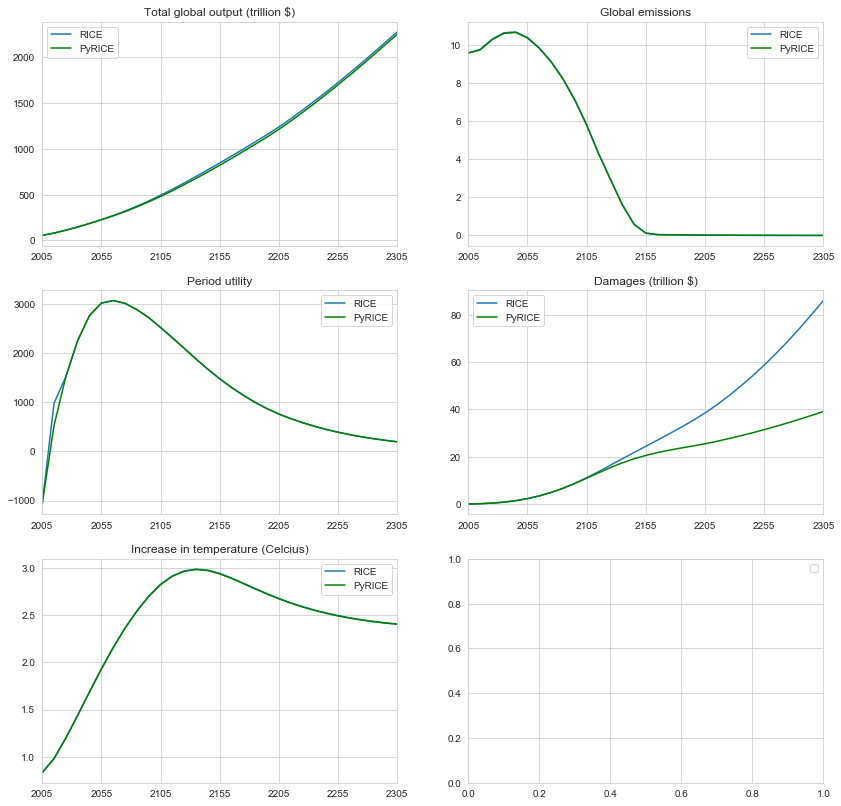

In [28]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

plot_df.iloc[:,0].plot(ax=axes[0,0],label="RICE"); axes[0,0].set_title('Total global output (trillion $)'), axes[0,0].legend()
plot_df.iloc[:,1].plot(ax=axes[0,0],label="PyRICE",secondary_y=False, style='g'); axes[0,0].legend()

plot_df.iloc[:,2].plot(ax=axes[0,1],label="RICE"); axes[0,1].set_title('Global emissions'), axes[0,1].legend()
plot_df.iloc[:,3].plot(ax=axes[0,1],label="PyRICE" ,secondary_y=False, style='g'); axes[0,1].legend()

plot_df.iloc[:,4].plot(ax=axes[1,0],label="RICE"); axes[1,0].set_title('Period utility'), axes[1,0].legend()
plot_df.iloc[:,5].plot(ax=axes[1,0],label="PyRICE",secondary_y=False, style='g'); axes[1,0].legend()

plot_df.iloc[:,6].plot(ax=axes[1,1],label="RICE"); axes[1,1].set_title('Damages (trillion $)'), axes[1,1].legend()
plot_df.iloc[:,7].plot(ax=axes[1,1],label="PyRICE",secondary_y=False, style='g');  axes[1,1].legend()

plot_df.iloc[:,8].plot(ax=axes[2,0],label="RICE"); axes[2,0].set_title('Increase in temperature (Celcius)'), axes[2,0].legend()
plot_df.iloc[:,9].plot(ax=axes[2,0],label="PyRICE",secondary_y=False, style='g'); axes[2,0].legend()

plt.legend()

In [29]:
output_sr = model.S[:,0:31]
output_sr = pd.DataFrame(data=output_sr,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_sr = output_sr.transpose()

output_miu = model.miu[:,0:31]
output_miu = pd.DataFrame(data=output_miu,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_miu = output_miu.transpose()

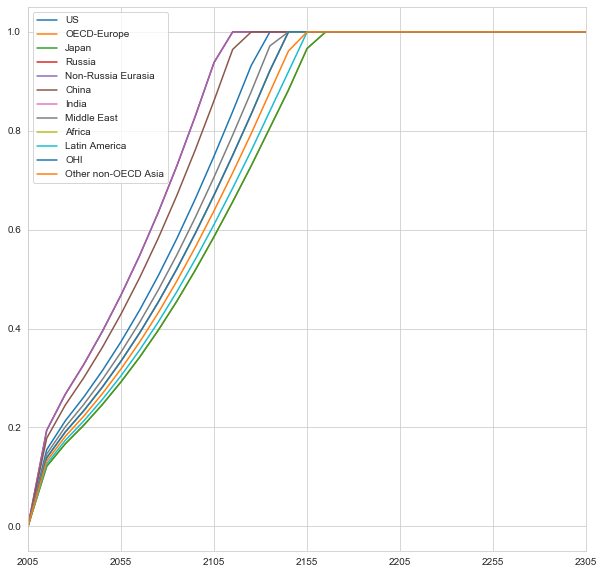

In [30]:
output_miu.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

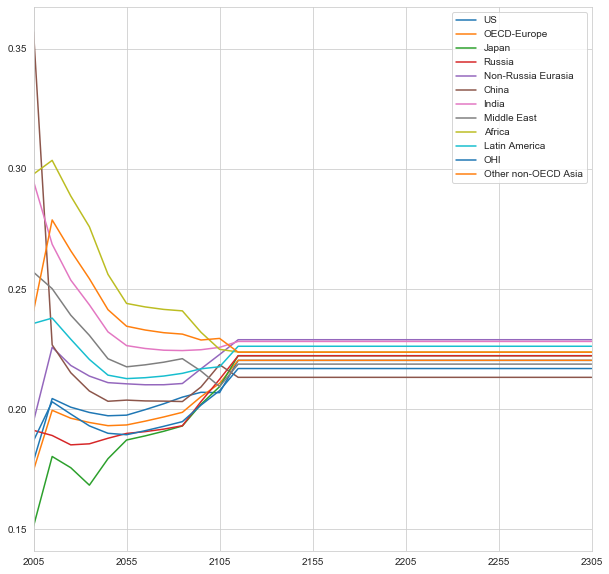

In [31]:
output_sr.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

In [23]:
sr_opt_series = validation_series.iloc[21:33,3:34]
sr_opt_series

,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
21,0.178518,0.204412,0.200811,0.198623,0.197245,0.197498,0.199787,0.202249,0.205001,0.207013,...,0.220303,0.220303,0.220303,0.220303,0.220303,0.220303,0.220303,0.220303,0.220303,0.220303
22,0.174643,0.199512,0.196217,0.194448,0.193118,0.193420,0.194999,0.196752,0.198678,0.205177,...,0.220336,0.220336,0.220336,0.220336,0.220336,0.220336,0.220336,0.220336,0.220336,0.220336
23,0.151305,0.180289,0.175611,0.168349,0.179363,0.187151,0.188868,0.190790,0.192995,0.202015,...,0.222269,0.222269,0.222269,0.222269,0.222269,0.222269,0.222269,0.222269,0.222269,0.222269
24,0.191169,0.189032,0.185134,0.185564,0.187874,0.189891,0.190648,0.191683,0.193081,0.203135,...,0.222233,0.222233,0.222233,0.222233,0.222233,0.222233,0.222233,0.222233,0.222233,0.222233
25,0.195007,0.225796,0.218190,0.213765,0.211040,0.210543,0.210152,0.210164,0.210678,0.216794,...,0.228909,0.228909,0.228909,0.228909,0.228909,0.228909,0.228909,0.228909,0.228909,0.228909
26,0.357081,0.226761,0.215165,0.207549,0.203280,0.203759,0.203424,0.203342,0.203167,0.209220,...,0.213244,0.213244,0.213244,0.213244,0.213244,0.213244,0.213244,0.213244,0.213244,0.213244
27,0.294846,0.268656,0.253734,0.243444,0.232184,0.226459,0.225263,0.224542,0.224393,0.224745,...,0.228191,0.228191,0.228191,0.228191,0.228191,0.228191,0.228191,0.228191,0.228191,0.228191
28,0.257002,0.250152,0.239122,0.230727,0.220982,0.217629,0.218454,0.219554,0.221015,0.215862,...,0.218755,0.218755,0.218755,0.218755,0.218755,0.218755,0.218755,0.218755,0.218755,0.218755
29,0.297889,0.303591,0.288742,0.275936,0.256133,0.244015,0.242566,0.241528,0.240923,0.232022,...,0.223782,0.223782,0.223782,0.223782,0.223782,0.223782,0.223782,0.223782,0.223782,0.223782
30,0.235704,0.237909,0.229123,0.220697,0.214161,0.212721,0.213096,0.213786,0.214911,0.216800,...,0.226188,0.226188,0.226188,0.226188,0.226188,0.226188,0.226188,0.226188,0.226188,0.226188


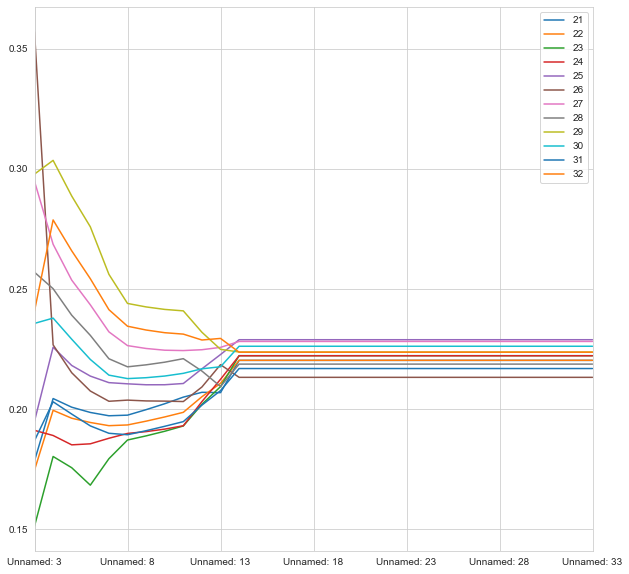

In [24]:
sr_opt_series.transpose().plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')